## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [ ]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style='darkgrid')
filterwarnings('ignore')

In [ ]:
x = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустингового (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

### Проверка кода

У автора задания всё учится около одной секунды.

In [ ]:
from boosting import Boosting
import time
boosting = Boosting()

start_time = time.time()
boosting.fit(x_train, y_train, x_valid, y_valid)
end_time = time.time()
print(f"Время выполнения: {end_time - start_time} секунд")

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

Время выполнения: 0.9557843208312988 секунд
Train ROC-AUC 0.9894
Valid ROC-AUC 0.9125
Test ROC-AUC 0.9135


## Задание 2. Обучение градиентного бустингового (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

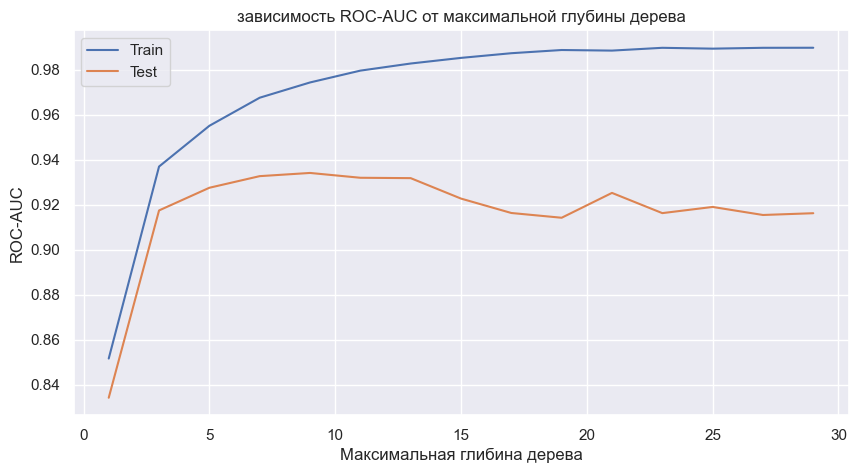

In [ ]:
from sklearn.metrics import roc_auc_score
results = {}

depths = range(1, 30, 2)

for depth in depths:
    boosting = Boosting(base_model_params={'max_depth': depth})
    boosting.fit(x_train, y_train, x_valid, y_valid)

    train_roc_auc = roc_auc_score(y_train, boosting.predict_proba(x_train)[:, 1])
    test_roc_auc = roc_auc_score(y_test, boosting.predict_proba(x_test)[:, 1])

    results[depth] = (train_roc_auc, test_roc_auc)

train_scores = [results[depth][0] for depth in depths]
test_scores = [results[depth][1] for depth in depths]

plt.figure(figsize=(10, 5))
plt.plot(depths, train_scores, label='Train')
plt.plot(depths, test_scores, label='Test')
plt.xlabel('Максимальная глибина дерева')
plt.ylabel('ROC-AUC')
plt.title('зависимость ROC-AUC от максимальной глубины дерева')
plt.legend()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

Качество на обучающей выборке продолжает расти с увеличением глубины дерева, модель лучше подстраивается под обучающие данные, что может включать заучивание шума и особенностей конкретной выборки данных. Происходит переобучение. Потому качество на тестовой выборке растет до определенной глубины дерева (в данном случае 7-9), после чего начинает или убывать, или колебаться без значимого улучшения.

Когда деревья слишком мелкие (глубина 1-4), модель не может зафиксировать все закономерности в данных, что приводит к недообучению.

Наилучшая модель — та, которая достигает компромисса между смещением (bias) и дисперсией (variance), тем самым максимизируя качество на тестовой выборке. На графике видно, что эта модель получается при глубине 7-9, соответствующая пику кривой тестовой выборки, что указывает на оптимальный баланс сложности модели и её способности к обобщению.

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (3 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей. Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/).

In [ ]:
import optuna

def optim_func(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        'subsample': trial.suggest_uniform('subsample', 0.3, 1.0),
        'base_model_params': {
            'max_depth': trial.suggest_int('max_depth', 1, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30)
        },
    }
    model = Boosting(**param)
    model.fit(x_train, y_train, x_valid, y_valid)
    roc_auc = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])

    return roc_auc

res = optuna.create_study(direction='maximize')
res.optimize(optim_func, n_trials=50)
print(res.best_params)


[I 2023-12-23 17:24:17,307] A new study created in memory with name: no-name-1fb43047-79b5-42cb-b71b-712f660c4ed1
[I 2023-12-23 17:24:26,389] Trial 0 finished with value: 0.9391088038070518 and parameters: {'n_estimators': 100, 'learning_rate': 0.04690455965468989, 'subsample': 0.8331696071855341, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 21}. Best is trial 0 with value: 0.9391088038070518.
[I 2023-12-23 17:24:32,722] Trial 1 finished with value: 0.9392177568758167 and parameters: {'n_estimators': 69, 'learning_rate': 0.024032847858353024, 'subsample': 0.607129737788044, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 18}. Best is trial 1 with value: 0.9392177568758167.
[I 2023-12-23 17:24:34,403] Trial 2 finished with value: 0.9334113165920757 and parameters: {'n_estimators': 25, 'learning_rate': 0.011280391524820405, 'subsample': 0.8440300958967408, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.939217756

[I 2023-12-23 17:27:02,223] Trial 27 finished with value: 0.9409937318062344 and parameters: {'n_estimators': 79, 'learning_rate': 0.15308517361219187, 'subsample': 0.8846621070142899, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 13}. Best is trial 22 with value: 0.9427673121637122.
[I 2023-12-23 17:27:06,821] Trial 28 finished with value: 0.9394799626127347 and parameters: {'n_estimators': 92, 'learning_rate': 0.3034346186648629, 'subsample': 0.7775792526852601, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 5}. Best is trial 22 with value: 0.9427673121637122.
[I 2023-12-23 17:27:17,511] Trial 29 finished with value: 0.9382463584532017 and parameters: {'n_estimators': 96, 'learning_rate': 0.16077029319626082, 'subsample': 0.9427482961826604, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 22 with value: 0.9427673121637122.
[I 2023-12-23 17:27:25,292] Trial 30 finished with value: 0.9394097218064978 and parameters: {'n_estimat

{'n_estimators': 100, 'learning_rate': 0.488686223677744, 'subsample': 0.8761981048737414, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 12}


## Задание 4. Интерпретация бустингового (2 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

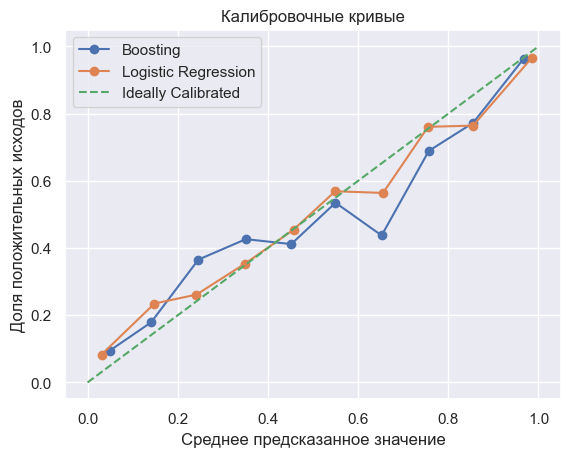

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from boosting import Boosting

best_params = {
    'n_estimators': res.best_params['n_estimators'],
    'learning_rate': res.best_params['learning_rate'],
    'subsample': res.best_params['subsample'],
    'base_model_params': {
        'max_depth': res.best_params['max_depth'],
        'min_samples_split': res.best_params['min_samples_split'],
        'min_samples_leaf': res.best_params['min_samples_leaf']
    }
}
best_boosting_model = Boosting(**best_params)
best_boosting_model.fit(x_train, y_train, x_valid, y_valid)


log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

prob_true_boosting, prob_pred_boosting = calibration_curve(y_test, best_boosting_model.predict_proba(x_test)[:, 1], n_bins=10)
prob_true_log_reg, prob_pred_log_reg = calibration_curve(y_test, log_reg.predict_proba(x_test)[:, 1], n_bins=10)

plt.plot(prob_pred_boosting, prob_true_boosting, marker='o', label='Boosting')
plt.plot(prob_pred_log_reg, prob_true_log_reg, marker='o', label='Logistic Regression')

plt.plot([0, 1], [0, 1], linestyle='--', label='Ideally Calibrated')
plt.xlabel('Среднее предсказанное значение')
plt.ylabel('Доля положительных исходов')
plt.title('Калибровочные кривые')
plt.legend()
plt.show()


Логистическая кривая наиболее близка к идеальной линии по сравнению с кривой бустинга. Это указывает на то, что вероятности, предсказанные логистической регрессии, довольно хорошо калиброваны, хотя и не идеальны. Кривая бустинга отклоняется сильнее от идеальной прямой, потому оценивает вероятности хуже.



Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.

Нарисуйте столбчатую диаграмму важности признаков. На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Проанализируйте полученные результаты.

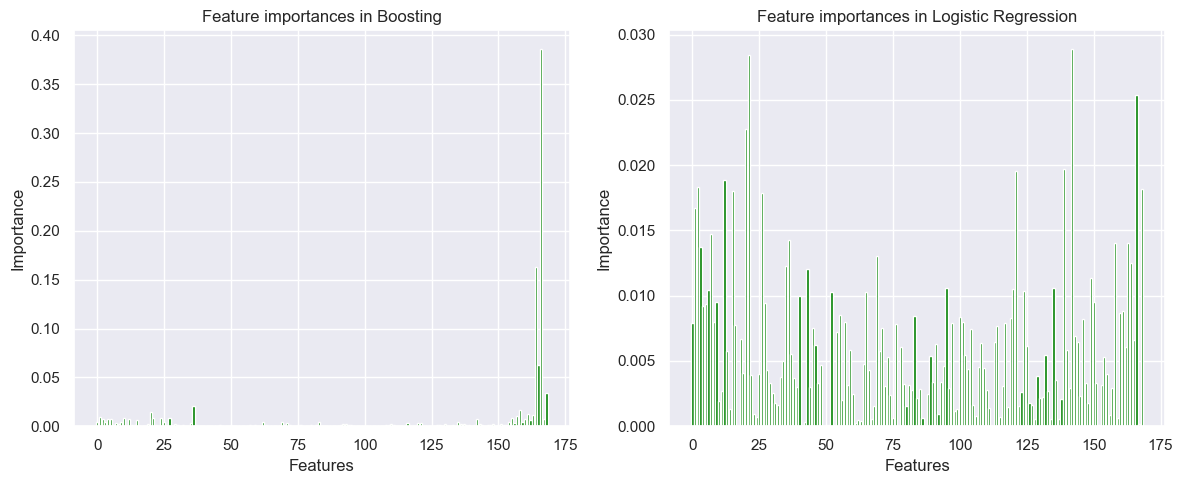

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances_boosting = best_boosting_model.feature_importances_

feature_importances_log_reg = np.abs(log_reg.coef_[0])
feature_importances_log_reg /= feature_importances_log_reg.sum()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(feature_importances_boosting)), feature_importances_boosting, color='green')
plt.title('Feature importances in Boosting')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.subplot(1, 2, 2)
plt.bar(range(len(feature_importances_log_reg)), feature_importances_log_reg, color='green')
plt.title('Feature importances in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()


Видим, что в бустинге есть примерно 10-20 признаков, которые имеют значимое влияние на предсказания модели, в то время как важность остальных признаков близка к 0

В Логистической регрессии же наоборот много признаков, которые имеют примерно равный вклад в предсказания модели.

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

In [ ]:
# YOUR CODE:

threshold = np.percentile(feature_importances_boosting, 70)

selected_features = np.where(feature_importances_boosting > threshold)[0]

x_train_filtered = x_train[:, selected_features]
x_valid_filtered = x_valid[:, selected_features]
x_test_filtered = x_test[:, selected_features]

filtered_boosting_model = Boosting(**best_params)
filtered_boosting_model.fit(x_train_filtered, y_train, x_valid_filtered, y_valid)

filtered_test_auc = roc_auc_score(y_test, filtered_boosting_model.predict_proba(x_test_filtered)[:, 1])
print(f'ROC-AUC после фильтрации признаков: {filtered_test_auc:.4f}')

best_boosting_model = Boosting(**best_params)
best_boosting_model.fit(x_train, y_train, x_valid, y_valid)
best_boosting_model_auc = roc_auc_score(y_test, best_boosting_model.predict_proba(x_test)[:, 1])
print(f'ROC-AUC лучшей модели: {best_boosting_model_auc:.4f}')

ROC-AUC после фильтрации признаков: 0.9393
ROC-AUC лучшей модели: 0.9402


Качество осталось примерно таким же (зависит от выбра threshold и запуска, но все примерно одинаково)

## Задание 5 (бонус). Блендинговое (1 балл)

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

boosting_predictions = best_boosting_model.predict_proba(x_test)[:, 1]
log_reg_predictions = log_reg.predict_proba(x_test)[:, 1]

blend_predictions = boosting_predictions * 0.5 + log_reg_predictions * 0.5 # берем среднее

blend_auc = roc_auc_score(y_test, blend_predictions)
print(f'ROC-AUC blend-модели: {blend_auc:.4f}')
print(f'ROC-AUC после фильтрации признаков: {filtered_test_auc:.4f}')
print(f'ROC-AUC лучшей модели: {best_boosting_model_auc:.4f}')

ROC-AUC blend-модели: 0.9412
ROC-AUC после фильтрации признаков: 0.9393
ROC-AUC лучшей модели: 0.9402


качество слегка улучшилось

## Задание 6 (бонус). Катбустовое (1 балл)

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

catboost_model = CatBoostClassifier(iterations=1000,
                                    learning_rate=0.1,
                                    depth=7,
                                    verbose=False)

catboost_model.fit(x_train, y_train, eval_set=(x_valid, y_valid))
catboost_predictions = catboost_model.predict_proba(x_test)[:, 1]

catboost_auc = roc_auc_score(y_test, catboost_predictions)
print(f'ROC-AUC для CatBoost: {catboost_auc:.4f}')
print(f'ROC-AUC blend-модели: {blend_auc:.4f}')
print(f'ROC-AUC после фильтрации признаков: {filtered_test_auc:.4f}')
print(f'ROC-AUC лучшей модели: {best_boosting_model_auc:.4f}')

ROC-AUC для CatBoost: 0.9403
ROC-AUC blend-модели: 0.9412
ROC-AUC после фильтрации признаков: 0.9393
ROC-AUC лучшей модели: 0.9402


CatBoost выдает результат похуже, чем blend-модель, но сравнимый с остальными моделями.